# Plotting 3D PTE analysis 

Original script taken from Georgios Papavasileiou (https://publikationen.bibliothek.kit.edu/1000123919)

Modified by Ting-Chen Chen (ting-chen.chen@kit.edu) in Feb, 2023

In [1]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs

exp80 = 'channel_80km_0004'
exp2 = 'channel_2km_0004'

compute_DIAB = True             # Always set 'True' when the explicity-calculated diabatic heating rate is available

data_res  = '1x1latlon'
dt        =  6                  # INTENDED delta t in hrs for the PTE analysis 
                                # (not the time interval of the input data) 

if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'

we load libraries

In [2]:
import numba
from numba import njit
import math
import psutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime  
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")
from platform import python_version
from netCDF4 import Dataset
import matplotlib.colors as colors

In [3]:
#print(numba.__version__)
print(python_version())

3.10.10


In [4]:
parallel_options = {
    'comprehension': True,  # parallel comprehension
    'prange':        True,  # parallel for-loop
    'numpy':         True,  # parallel numpy calls
    'reduction':     True,  # parallel reduce calls
    'setitem':       True,  # parallel setitem
    'stencil':       True,  # parallel stencils
    'fusion':        False,  # enable fusion or not
}

In [5]:
def print_memory(msg=None):
    process = psutil.Process()
    if (msg):
        print(msg, ':', 'memory =', np.round(process.memory_info().rss/(1024*1024)), 'MB')
    else:
        print('memory =', np.round(process.memory_info().rss/(1024*1024)), 'MB')

In [6]:
#####################################################
# Read in track data from file
#####################################################
#Cyclone Track
path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

df_track80 = pd.read_csv(path_track+'Track_for_'+exp80+'_'+str(dt)+'hrly_1x1latlon.csv')

# get timesteps from map
#tmin = time.min()
#tmax = time.max()

# select timesteps from track
#df_track = df_track.loc[(df_track['time']>=tmin) & (df_track['time']<=tmax)]

# determine timesteps of track
ntrack = len(df_track80['lat'])

track_dur80  = df_track80['time']
track_lon80  = df_track80['lon']
track_lat80  = df_track80['lat']
    

df_track2= pd.read_csv(path_track+'Track_for_'+exp2+'_'+str(dt)+'hrly_1x1latlon.csv')

# get timesteps from map
#tmin = time.min()
#tmax = time.max()

# select timesteps from track
#df_track = df_track.loc[(df_track['time']>=tmin) & (df_track['time']<=tmax)]


track_dur2  = df_track2['time']
track_lon2  = df_track2['lon']
track_lat2  = df_track2['lat']
    
df_track2



Unnamed: 0  time         pmin   lon   lat
0            0  0.00  1000.991638  56.5  27.5
1            1  0.25   997.934448  61.5  23.5
2            2  0.50   998.462646  21.5  42.5
3            3  0.75   997.014771  32.5  28.5
4            4  1.00   999.559631  27.5  42.5
5            5  1.25   997.670227  27.5  43.5
6            6  1.50   998.062012  31.5  44.5
7            7  1.75   997.686157  40.5  42.5
8            8  2.00   997.231018  45.5  44.5
9            9  2.25   995.639587  49.5  43.5
10          10  2.50   993.030029  52.5  44.5
11          11  2.75   988.784302  56.5  44.5
12          12  3.00   985.596008  59.5  45.5
13          13  3.25   981.169678  14.5  45.5
14          14  3.50   976.026123  17.5  46.5
15          15  3.75   970.745728  19.5  46.5
16          16  4.00   967.672241  23.5  47.5
17          17  4.25   966.600647  28.5  47.5
18          18  4.50   963.127014  34.5  48.5
19          19  4.75   961.268616  37.5  48.5
20          20  5.00   960.033142  42.5  49.5
21          21  5.25   959.165527  46.5  49.5
22          22  5.50   954.482788  54.5  50.5
23          23  5.75   950.702515  60.5  50.5
24          24  6.00   944.416199  13.5  51.5
25          25  6.25   939.254089  14.5  51.5
26          26  6.50   943.386414  15.5  50.5
27          27  6.75   944.307129  23.5  52.5
28          28  7.00   945.061279  28.5  53.5
29          29  7.25   945.369507  34.5  52.5
30          30  7.50   945.417725  34.5  53.5
31          31  7.75   945.800781  39.5  53.5
32          32  8.00   948.895386  39.5  53.5
33          33  8.25   952.656189  45.5  53.5
34          34  8.50   955.252869  55.5  50.5
35          35  8.75   962.483459  54.5  51.5
36          36  9.00   963.767273  24.5  46.5

In [7]:

#####################################################
# Read in PTE data from file
#####################################################


# path on Levante for the PTE calculated results (2D maps for all selected time steps)
ipath = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/maps/'

#ifile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa.nc"
ifile80 = "For_paper_"+exp80+"_"+data_dt+"_"+data_res+"_TADV_Qdot.nc"
ifile2 = "For_paper_"+exp2+"_"+data_dt+"_"+data_res+"_TADV_Qdot.nc"

# read the data
data_file80= ipath+ifile80
nc       = Dataset(data_file80, mode='r')
lons     = nc.variables['lon'][:]
lats     = nc.variables['lat'][:]
level    = nc.variables['lev'][:]    
time     = nc.variables['time'][:]
mslp     = nc.variables['mslp'][:]
tadv     = nc.variables['tadv'][:]
geopot   = nc.variables['geopot'][:]
u        = nc.variables['u'][:]
v        = nc.variables['v'][:]
Tv       = nc.variables['Tv'][:]
omega    = nc.variables['omega'][:]
dTdt     = nc.variables['dTdt'][:]
dTdt_LH  = nc.variables['dTdt_LH'][:]
dTdt_Conv= nc.variables['dTdt_Conv'][:]

data_file2= ipath+ifile2
nc2       = Dataset(data_file2, mode='r')

mslp2     = nc2.variables['mslp'][:]
tadv2     = nc2.variables['tadv'][:]
geopot2   = nc2.variables['geopot'][:]
u2        = nc2.variables['u'][:]
v2        = nc2.variables['v'][:]
Tv2       = nc2.variables['Tv'][:]
omega2    = nc2.variables['omega'][:]
dTdt2     = nc2.variables['dTdt'][:]
dTdt_LH2  = nc2.variables['dTdt_LH'][:]
dTdt_Conv2= nc2.variables['dTdt_Conv'][:]

nlons = len(lons)

# Some Test Plots

250.0  (hPa)
500.0  (hPa)
850.0  (hPa)
r,c= 0 0 stp= 10 cen_lat= 47.5
r,c= 0 1 stp= 14 cen_lat= 49.5
r,c= 0 2 stp= 16 cen_lat= 49.5
r,c= 1 0 stp= 10 cen_lat= 47.5
r,c= 1 1 stp= 14 cen_lat= 49.5
r,c= 1 2 stp= 16 cen_lat= 49.5
r,c= 2 0 stp= 10 cen_lat= 47.5
r,c= 2 1 stp= 14 cen_lat= 49.5
r,c= 2 2 stp= 16 cen_lat= 49.5
r,c= 3 0 stp= 10 cen_lat= 47.5
r,c= 3 1 stp= 14 cen_lat= 49.5
r,c= 3 2 stp= 16 cen_lat= 49.5


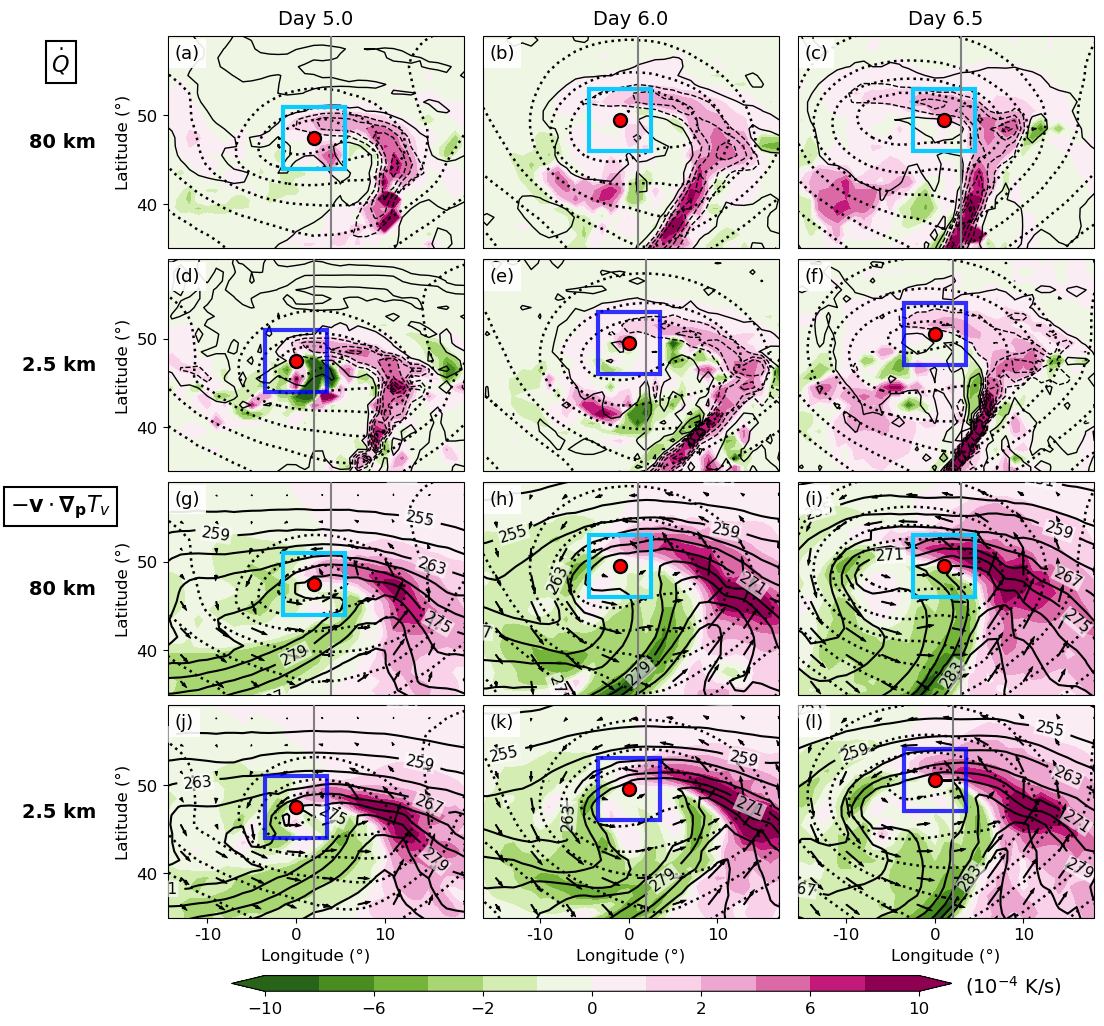

In [8]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'
lonmin=lons.min()+10.5
lonmax=lons.max()-6

latmin0=35
latmax0=58
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp0 = 10   #5 day
stp2 = 14   #6ay
#stp3 = 17 # stp=16: 6.75 day 
stp3 = 16 # stp=16: 6.5 day  
#stp3 = 20 # stp=16: 6.75 day 


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'PiYG_r'
clevsomg=np.arange(-180,210,30)
# --------------------------------------------

print (level[lev1]/100,' (hPa)')
print (level[lev2]/100,' (hPa)')
print (level[lev3]/100,' (hPa)')

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(900,1060,10)
#clevs=np.arange(-10.8e-4,12.6e-4,1.8e-4)
clevs=[-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10]
clevs_tv=np.arange(199,295,4)

norm = colors.BoundaryNorm(clevs, ncolors=256)

shift_lon0=14
    #shift_lon=0
shift_lon2= -3
    #shift_lon3=0
    #shift_lon3=-16 # for CTL
    #shift_lon3=-7 # for Tanom
shift_lon3=-16 #or Tanom

for i in range(ntrack):
    #find timestep corresponding to track and data
    if track_dur80[i] == time[stp0]  :
        cen_lon80_0=track_lon80[i]+shift_lon0
        cen_lat80_0=track_lat80[i]

    if track_dur80[i] == time[stp2]  :
        cen_lon80_2=track_lon80[i]+shift_lon2
        cen_lat80_2=track_lat80[i]    
        
    if track_dur80[i] == time[stp3]  :
        cen_lon80_3=track_lon80[i]+shift_lon3
        cen_lat80_3=track_lat80[i]
       
    if track_dur2[i] == time[stp0]  :
        cen_lon2_0=track_lon2[i]+shift_lon0
        cen_lat2_0=track_lat2[i]
      
    if track_dur2[i] == time[stp2]  :
        cen_lon2_2=track_lon2[i]+shift_lon2
        cen_lat2_2=track_lat2[i]
      
        
    if track_dur2[i] == time[stp3]  :
        cen_lon2_3=track_lon2[i]+shift_lon3
        cen_lat2_3=track_lat2[i]
   

fig = plt.figure(figsize=(12,10.5))
nrows = 4
ncols = 3
plotnum = 1
        
for r in range(0,nrows):
    for c in range(0,ncols): 
        
        lev = lev3
        
        if r == 0 or r== 2:
            tadv0 = tadv
            mslp0 = mslp
            geopot0 = geopot
            u0 = u
            v0 = v
            Tv0 = Tv
            omega0 = omega
            dTdt0 = dTdt
            res = '80 km'
        elif r == 1 or r ==3:
            tadv0 = tadv2
            mslp0 = mslp2
            geopot0 = geopot2
            u0 = u2
            v0 = v2
            Tv0 = Tv2
            omega0 = omega2
            dTdt0 = dTdt2
            res = '2.5 km'
            
        if c == 0 :
            stp = stp0
            cen_lon = cen_lon80_0
            cen_lat = cen_lat80_0
            cen_lon2 = cen_lon2_0
            cen_lat2 = cen_lat2_0
            shift_lon= shift_lon0
        elif c == 1:
            stp = stp2
            cen_lon = cen_lon80_2
            cen_lat = cen_lat80_2
            cen_lon2 = cen_lon2_2
            cen_lat2 = cen_lat2_2
            shift_lon= shift_lon2
        elif c == 2:
            stp = stp3
            cen_lon = cen_lon80_3
            cen_lat = cen_lat80_3
            cen_lon2 = cen_lon2_3
            cen_lat2 = cen_lat2_3
            shift_lon= shift_lon3
     
        TADV_avg_roll =np.roll(tadv0,shift_lon, axis=3)
        mslp_roll =np.roll(mslp0,shift_lon,axis=2)
        geopot_roll =np.roll(geopot0/9.8,shift_lon,axis=3)
        u_roll =np.roll(u0,shift_lon,axis=3)
        v_roll =np.roll(v0,shift_lon,axis=3)
        Tv_roll =np.roll(Tv0,shift_lon,axis=3)
        omega_roll =np.roll(omega0*100,shift_lon, axis=3)
        dTdt_nwp_roll =np.roll(dTdt0,shift_lon, axis=3)
       
        print ('r,c=',r,c,'stp=',stp,'cen_lat=',cen_lat)
        if r >=  2: # Plot TADV 
                
            ax1 = plt.subplot(nrows,ncols,plotnum,projection=ccrs.PlateCarree())
            ax1.set_extent([lonmin, lonmax, latmin0, latmax0])    
            cd = plt.contourf(lons,lats,TADV_avg_roll[stp,lev,:,:]*1e4,clevs,cmap=cmap,norm=norm, extend='both',transform=ccrs.PlateCarree())
            cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.8
                            ,transform=ccrs.PlateCarree())
            cst = plt.contour(lons,lats,Tv_roll[stp,lev,:,:],clevs_tv,colors=ctv,linewidths=1.5,transform=ccrs.PlateCarree())
            Q=plt.quiver(lons[::4],lats[::3],u_roll[stp,lev, ::3,::4],v_roll[stp,lev,::3,::4], scale=150,scale_units='inches', edgecolors='k',linewidths=0.7, transform=ccrs.PlateCarree())

            clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=11) 
            [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
                
        else: # Plot DIAB
            
            ax1 = plt.subplot(nrows,ncols,plotnum,projection=ccrs.PlateCarree())
            ax1.set_extent([lonmin, lonmax, latmin0, latmax0])    
            cd = plt.contourf(lons,lats,dTdt_nwp_roll[stp,lev,:,:]*1e4,clevs,cmap=cmap,norm=norm, extend='both',transform=ccrs.PlateCarree())
            cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.8
                            ,transform=ccrs.PlateCarree())
            cst = plt.contour(lons,lats,omega_roll[stp,lev,:,:],clevsomg,colors=ctv,linewidths=1.0,transform=ccrs.PlateCarree())

         #  clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=12)
         #  [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
            
        #for l in clabels:
        #    l.set_rotation(0)
        #gl = ax1.gridlines(linewidth=0)
        #if r == 3:
        #    gl.xlabels_bottom = True
        #else:
        #    gl.xlabels_bottom = False
        #if c == 0:
        #    gl.ylabels_left = True
        #else:
        #    gl.ylabels_left = False
        #gl.xformatter =LONGITUDE_FORMATTER
        #gl.yformatter =LATITUDE_FORMATTER
        #gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
        #gl.ylocator = mticker.FixedLocator(np.arange(10,90,5))
        #gl.xlabel_style = {'size': 10, 'color': 'k'}
        #gl.ylabel_style = {'size': 10, 'color': 'k'}

        if c==0:
            ax1.set_yticks([40,50])
            ax1.set_ylabel('Latitude (°)',fontsize=12)
            ax1.set_yticklabels(['40','50'])
        if r==3:
            ax1.set_xticks([cen_lon2-10,cen_lon2,cen_lon2+10])
            ax1.set_xlabel('Longitude (°)',fontsize=12)
            ax1.set_xticklabels([-10,0,10])
        ax1.tick_params(axis='both', labelsize=12)
        
        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
        

        boxsize = 7 # horizontal size of column in deg used for PTE analysis

        if r == 0 or r == 2:
            plt.scatter(cen_lon, cen_lat, c='k', s=100, zorder=20)
            plt.scatter(cen_lon, cen_lat, c='r', s=45, zorder=20)
            plt.vlines(x = cen_lon+2, ymin = 20, ymax=65, color="gray",linestyle='-',linewidth=1.5,zorder=22,transform=ccrs.PlateCarree())
            ax1.add_patch(plt.Rectangle((cen_lon-boxsize/2,
                                 cen_lat-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 ec='#0ACBFF',
                                 ls='solid',
                                 linewidth=3,
                                 zorder=20,
                                 alpha=1.0))
        #========================================
        #if res == '2km':
        else:
            plt.scatter(cen_lon2,cen_lat2,c='k', s=100, zorder=20)
            plt.scatter(cen_lon2,cen_lat2,c='r', s=45, zorder=20)
            plt.vlines(x = cen_lon2+2, ymin = 20, ymax=65, color="gray",linestyle='-',linewidth=1.5,zorder=22,transform=ccrs.PlateCarree())
            #plt.scatter(cen_lon80, cen_lat80, c='orange', s=80, zorder=25,transform=ccrs.PlateCarree())
            ax1.add_patch(plt.Rectangle((cen_lon2-boxsize/2,
                                 cen_lat2-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 ec='blue',
                                 ls='solid',
                                 linewidth=3,
                                 zorder=19,
                                 alpha=0.8))
         #========================================
            
        if r == 0 and c == 0:
             
            xtxt = -0.36
            ytxt = 0.95

            ax1.text(xtxt, ytxt,
                 ''r'$\dot Q$',
                # 'Day '+str(stp*0.25+2.5),
                 ha='center',
                 va='top',
                 weight='bold',
                 fontsize=16,
                 bbox=dict(ec='k',
                 fc='white',linewidth=1.5),
                 transform=ax1.transAxes, zorder=50)
        if r == 2 and c == 0:
             
            #xtxt = 0.05
            #ytxt = 0.84
            xtxt = -0.36
            ytxt = 0.95

            ax1.text(xtxt, ytxt,
                 ''r'$-\mathbf{v}\cdot\mathbf{\nabla_p}T_v$',
                # 'Day '+str(stp*0.25+2.5),
                 ha='center',
                 va='top',
                 weight='bold',
                 fontsize=16,
                 bbox=dict(ec='k',
                 fc='white',linewidth=1.5),
                 transform=ax1.transAxes, zorder=50)
            
       
        if plotnum == 1:
            text = '(a)'
        elif plotnum == 2:
            text = '(b)' 
        elif plotnum == 3:
            text = '(c)'
        elif plotnum == 4:
            text = '(d)'
        elif plotnum == 5:
            text = '(e)'
        elif plotnum == 6:
            text = '(f)'
        elif plotnum == 7:
            text = '(g)'
        elif plotnum == 8:
            text = '(h)'
        elif plotnum == 9:
            text = '(i)'
        elif plotnum == 10:
            text = '(j)'
        elif plotnum == 11:
            text = '(k)'
        elif plotnum == 12:
            text = '(l)'
 
        plt.text(0.025,0.96, text, ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax1.transAxes, fontsize=13, zorder=60) 

        if c == 0:
            ax1.text(-0.24, 0.5, ''+(res)+'',
                    horizontalalignment='right',
                    verticalalignment='center',
                    #rotation='vertical',
                    fontsize=14,
                    fontweight='bold',
                    #bbox=dict(ec='k',
                    #fc='white'), 
                    transform=ax1.transAxes)
        if r == 0:
            ax1.text(0.5, 1.08,  'Day '+str(stp*0.25+2.5),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=14,
                    #fontweight='bold',
                    #bbox=dict(ec='k',
                    #fc='white'), 
                    transform=ax1.transAxes)
       #if plotnum == 7 or plotnum == 10:
       #    plt.quiverkey(Q,0,0.95, 20,'20 m/s',labelpos='E',coordinates='figure')

        plotnum = plotnum+1


##


fig.subplots_adjust(wspace = 0.05, hspace = 0.05)
fig.subplots_adjust(bottom=0.04)
cbar_ax = fig.add_axes([0.18, -0.03, 0.6, 0.015]) # left,bottom,width,height
clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        
        
#cb = fig.colorbar(cd, cax=cbar_ax, orientation='horizontal', extend='max')
tick_font_size = 12
clb.ax.tick_params(labelsize=tick_font_size)
clb.ax.set_title('('r'${10}^{-4}$'' K/s)', fontsize=14, x=1.07, y=-0.1, ha='left',
             transform=clb.ax.transAxes)

#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
plt.savefig('Fig13_Tadv_diab_threetimesteps_80vs2km.png', bbox_inches='tight',dpi=100)
plt.show()

250.0  (hPa)
500.0  (hPa)
850.0  (hPa)
r,c= 0 0 stp= 10 cen_lat= 47.5
cen_lat= 47.5
r,c= 0 1 stp= 14 cen_lat= 49.5
cen_lat= 49.5
r,c= 0 2 stp= 16 cen_lat= 49.5
cen_lat= 49.5
r,c= 1 0 stp= 10 cen_lat= 47.5
cen_lat= 47.5
r,c= 1 1 stp= 14 cen_lat= 49.5
cen_lat= 49.5
r,c= 1 2 stp= 16 cen_lat= 49.5
cen_lat= 50.5
r,c= 2 0 stp= 10 cen_lat= 47.5
cen_lat= 47.5
r,c= 2 1 stp= 14 cen_lat= 49.5
cen_lat= 49.5
r,c= 2 2 stp= 16 cen_lat= 49.5
cen_lat= 49.5
r,c= 3 0 stp= 10 cen_lat= 47.5
cen_lat= 47.5
r,c= 3 1 stp= 14 cen_lat= 49.5
cen_lat= 49.5
r,c= 3 2 stp= 16 cen_lat= 49.5
cen_lat= 50.5


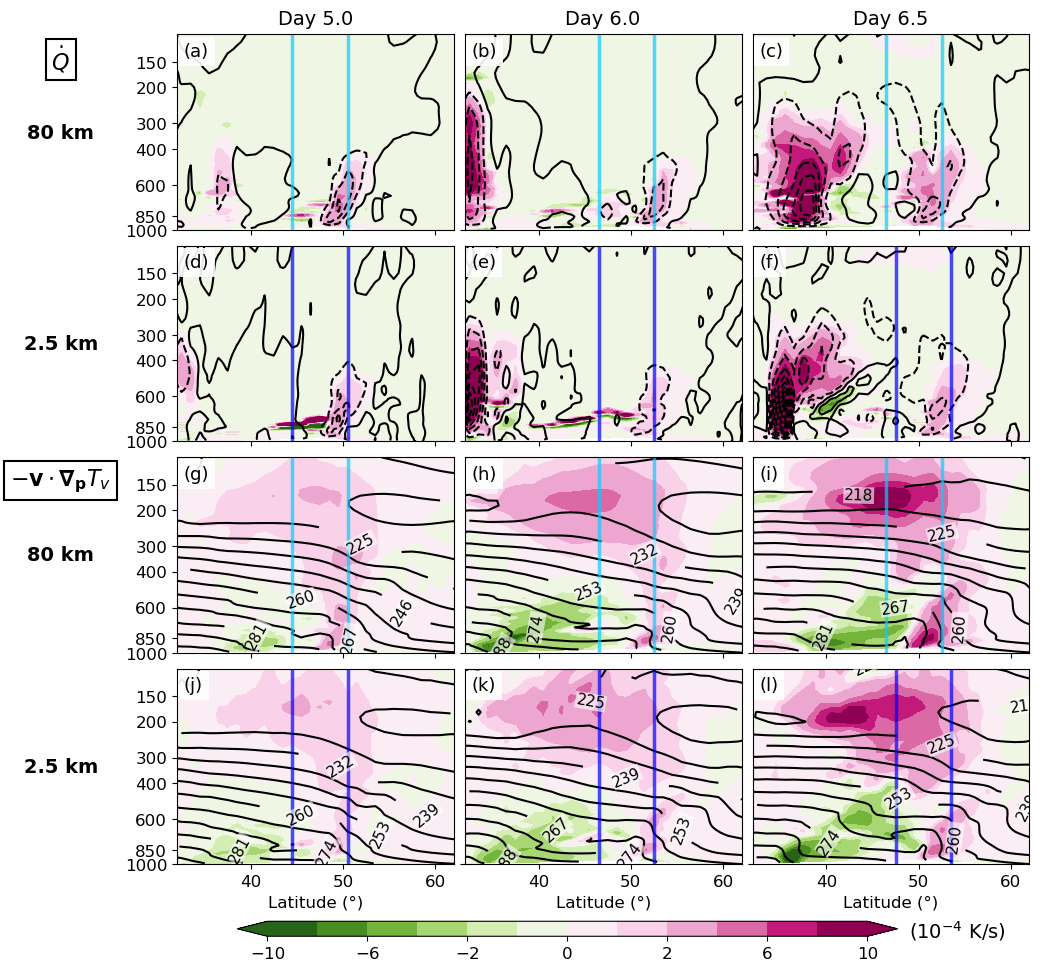

In [28]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'
lonmin=lons.min()+10.5
lonmax=lons.max()-6

latmin0=35
latmax0=58
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp0 = 10   #5 day
stp2 = 14   #6ay
#stp3 = 17 # stp=16: 6.75 day 
stp3 = 16 # stp=16: 6.5 day  
#stp3 = 20 # stp=16: 6.75 day 


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'PiYG_r'
clevsomg=np.arange(-300,330,30)
# --------------------------------------------

print (level[lev1]/100,' (hPa)')
print (level[lev2]/100,' (hPa)')
print (level[lev3]/100,' (hPa)')

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(900,1060,10)
#clevs=np.arange(-10.8e-4,12.6e-4,1.8e-4)
#clevs=[-10e-4,-8e-4,-6e-4,-4e-4,-2e-4,-1e-4,0,1e-4,2e-4,4e-4,6e-4,8e-4,10e-4 ]
clevs=[-10,-8,-6,-4,-2,-1,0,1,2,4,6,8,10]
clevs_tv=np.arange(190,350,7)

norm = colors.BoundaryNorm(clevs, ncolors=256)

shift_lon0=14
    #shift_lon=0
shift_lon2= -3
    #shift_lon3=0
    #shift_lon3=-16 # for CTL
    #shift_lon3=-7 # for Tanom
shift_lon3=-16 #or Tanom

for i in range(ntrack):
    #find timestep corresponding to track and data
    if track_dur80[i] == time[stp0]  :
        cen_lon80_0=track_lon80[i]+shift_lon0
        cen_lat80_0=track_lat80[i]

    if track_dur80[i] == time[stp2]  :
        cen_lon80_2=track_lon80[i]+shift_lon2
        cen_lat80_2=track_lat80[i]    
        
    if track_dur80[i] == time[stp3]  :
        cen_lon80_3=track_lon80[i]+shift_lon3
        cen_lat80_3=track_lat80[i]
       
    if track_dur2[i] == time[stp0]  :
        cen_lon2_0=track_lon2[i]+shift_lon0
        cen_lat2_0=track_lat2[i]
      
    if track_dur2[i] == time[stp2]  :
        cen_lon2_2=track_lon2[i]+shift_lon2
        cen_lat2_2=track_lat2[i]
      
        
    if track_dur2[i] == time[stp3]  :
        cen_lon2_3=track_lon2[i]+shift_lon3
        cen_lat2_3=track_lat2[i]
   
    for lo in range(nlons):
        if lons [lo] == cen_lon80_0+2:
            loc80_0 = lo
        if lons [lo] == cen_lon80_2+2:
            loc80_2 = lo
        if lons [lo] == cen_lon80_3+2:
            loc80_3 = lo
        if lons [lo] == cen_lon2_0+2:
            loc2_0 = lo
        if lons [lo] == cen_lon2_2+2:
            loc2_2 = lo
        if lons [lo] == cen_lon2_3+2:
            loc2_3 = lo
            
fig = plt.figure(figsize=(11,10))
nrows = 4
ncols = 3
plotnum = 1
        
for r in range(0,nrows):
    for c in range(0,ncols): 
        
        lev = lev3
        
        if r == 0 or r== 2:
            tadv0 = tadv
            mslp0 = mslp
            geopot0 = geopot
            u0 = u
            v0 = v
            Tv0 = Tv
            omega0 = omega
            dTdt0 = dTdt
            res = '80 km'
        elif r == 1 or r ==3:
            tadv0 = tadv2
            mslp0 = mslp2
            geopot0 = geopot2
            u0 = u2
            v0 = v2
            Tv0 = Tv2
            omega0 = omega2
            dTdt0 = dTdt2
            res = '2.5 km'
            
        if c == 0 :
            stp = stp0
            cen_lon = cen_lon80_0
            cen_lat = cen_lat80_0
            cen_lon2 = cen_lon2_0
            cen_lat2 = cen_lat2_0
            shift_lon= shift_lon0
            loc  = loc80_0
            loc2 = loc2_0
        elif c == 1:
            stp = stp2
            cen_lon = cen_lon80_2
            cen_lat = cen_lat80_2
            cen_lon2 = cen_lon2_2
            cen_lat2 = cen_lat2_2
            shift_lon= shift_lon2
            loc  = loc80_2
            loc2 = loc2_2
        elif c == 2:
            stp = stp3
            cen_lon = cen_lon80_3
            cen_lat = cen_lat80_3
            cen_lon2 = cen_lon2_3
            cen_lat2 = cen_lat2_3
            shift_lon= shift_lon3
            loc  = loc80_3
            loc2 = loc2_3
     
        TADV_avg_roll =np.roll(tadv0,shift_lon, axis=3)
        mslp_roll =np.roll(mslp0,shift_lon,axis=2)
        geopot_roll =np.roll(geopot0/9.8,shift_lon,axis=3)
        u_roll =np.roll(u0,shift_lon,axis=3)
        v_roll =np.roll(v0,shift_lon,axis=3)
        Tv_roll =np.roll(Tv0,shift_lon,axis=3)
        omega_roll =np.roll(omega0*100,shift_lon, axis=3)
        dTdt_nwp_roll =np.roll(dTdt0,shift_lon, axis=3)
       
        print ('r,c=',r,c,'stp=',stp,'cen_lat=',cen_lat)
        if r ==  2: # Plot TADV 
                
            ax1 = plt.subplot(nrows,ncols,plotnum)
            cd = plt.contourf(lats,level/100.,
                  TADV_avg_roll[stp,:,:,loc]*1e4,clevs,extend='both',cmap=cmap,norm=norm)
            cst = plt.contour(lats,level/100.,
                  Tv_roll[stp,:,:,loc],clevs_tv,colors=ctv)
            #cd = plt.contourf(lons,lats,TADV_avg_roll[stp,lev,:,:],clevs,cmap=cmap,norm=norm, extend='both',transform=ccrs.PlateCarree())
            #cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.0
            #                ,transform=ccrs.PlateCarree())
            #cst = plt.contour(lons,lats,Tv_roll[stp,lev,:,:],clevs_tv,colors=ctv,linewidths=1.5,transform=ccrs.PlateCarree())
            #Q=plt.quiver(lons[::4],lats[::2],u_roll[stp,lev, ::2,::4],v_roll[stp,lev,::2,::4], scale=150,scale_units='inches', edgecolors='k',transform=ccrs.PlateCarree())

            clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=11) 
            [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
        elif r ==  3: # Plot TADV 
                
            ax1 = plt.subplot(nrows,ncols,plotnum)
            cd = plt.contourf(lats,level/100.,
                  TADV_avg_roll[stp,:,:,loc2]*1e4,clevs,extend='both',cmap=cmap,norm=norm,)
            cst = plt.contour(lats,level/100.,
                  Tv_roll[stp,:,:,loc2],clevs_tv,colors=ctv)
            #cd = plt.contourf(lons,lats,TADV_avg_roll[stp,lev,:,:],clevs,cmap=cmap,norm=norm, extend='both',transform=ccrs.PlateCarree())
            #cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.0
            #                ,transform=ccrs.PlateCarree())
            #cst = plt.contour(lons,lats,Tv_roll[stp,lev,:,:],clevs_tv,colors=ctv,linewidths=1.5,transform=ccrs.PlateCarree())
            #Q=plt.quiver(lons[::4],lats[::2],u_roll[stp,lev, ::2,::4],v_roll[stp,lev,::2,::4], scale=150,scale_units='inches', edgecolors='k',transform=ccrs.PlateCarree())

            clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=11) 
            [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]    
    
        elif r == 0: # Plot DIAB
            
            ax1 = plt.subplot(nrows,ncols,plotnum)
            cd = plt.contourf(lats,level/100.,
                  dTdt_nwp_roll[stp,:,:,loc]*1e4,clevs,extend='both',cmap=cmap,norm=norm)
            cst = plt.contour(lats,level/100.,
                  omega_roll[stp,:,:,loc],clevsomg,colors=ctv)
        elif r == 1: # Plot DIAB
            
            ax1 = plt.subplot(nrows,ncols,plotnum)
            cd = plt.contourf(lats,level/100.,
                  dTdt_nwp_roll[stp,:,:,loc2]*1e4,clevs,extend='both',cmap=cmap,norm=norm)
            cst = plt.contour(lats,level/100.,
                  omega_roll[stp,:,:,loc2],clevsomg,colors=ctv)
           # cd = plt.contourf(lons,lats,dTdt_nwp_roll[stp,lev,:,:],clevs,cmap=cmap,norm=norm, extend='both',transform=ccrs.PlateCarree())
           # cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.0
          #                  ,transform=ccrs.PlateCarree())
           # cst = plt.contour(lons,lats,omega_roll[stp,lev,:,:],clevsomg,colors=ctv,linewidths=1.0,transform=ccrs.PlateCarree())

         #  clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=12)
         #  [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
            
        #for l in clabels:
        #    l.set_rotation(0)
        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
        

        if r == 0 and c == 0:
             
            xtxt = -0.42
            ytxt = 0.95

            ax1.text(xtxt, ytxt,
                 ''r'$\dot Q$',
                # 'Day '+str(stp*0.25+2.5),
                 ha='center',
                 va='top',
                 weight='bold',
                 fontsize=16,
                 bbox=dict(ec='k',
                 fc='white',linewidth=1.5),
                 transform=ax1.transAxes, zorder=50)
        if r == 2 and c == 0:
             
            #xtxt = 0.05
            #ytxt = 0.84
            xtxt = -0.42
            ytxt = 0.95

            ax1.text(xtxt, ytxt,
                 ''r'$-\mathbf{v}\cdot\mathbf{\nabla_p}T_v$',
                # 'Day '+str(stp*0.25+2.5),
                 ha='center',
                 va='top',
                 weight='bold',
                 fontsize=16,
                 bbox=dict(ec='k',
                 fc='white',linewidth=1.5),
                 transform=ax1.transAxes, zorder=50)
            
        if r == 0 or r == 2:
            #plt.scatter(cen_lat,950, c='k', s=100, zorder=20)
            #plt.scatter(cen_lat,950, c='r', s=45, zorder=20)
            plt.vlines(x = cen_lat-3, ymin = 1000, ymax=50, colors = '#0ACBFF',linestyles='-', linewidths=2.5,alpha=0.7)
            plt.vlines(x = cen_lat+3, ymin = 1000, ymax=50, colors = '#0ACBFF',linestyles='-', linewidths=2.5,alpha=0.7)
            print('cen_lat=',cen_lat)
        #========================================
        #if res == '2km':
        else:
           # plt.scatter(cen_lat2,950,c='k', s=100, zorder=20)
           # plt.scatter(cen_lat2,950,c='r', s=45, zorder=20)
            plt.vlines(x = cen_lat2-3, ymin = 1000, ymax=50, colors = 'blue',linestyles='-', linewidths=2.5,alpha=0.7)
            plt.vlines(x = cen_lat2+3, ymin = 1000, ymax=50, colors = 'blue',linestyles='-', linewidths=2.5,alpha=0.7)
            print('cen_lat=',cen_lat2)
        if plotnum == 1:
            text = '(a)'
        elif plotnum == 2:
            text = '(b)' 
        elif plotnum == 3:
            text = '(c)'
        elif plotnum == 4:
            text = '(d)'
        elif plotnum == 5:
            text = '(e)'
        elif plotnum == 6:
            text = '(f)'
        elif plotnum == 7:
            text = '(g)'
        elif plotnum == 8:
            text = '(h)'
        elif plotnum == 9:
            text = '(i)'
        elif plotnum == 10:
            text = '(j)'
        elif plotnum == 11:
            text = '(k)'
        elif plotnum == 12:
            text = '(l)'
 
        plt.text(0.025,0.96, text, ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax1.transAxes, fontsize=13, zorder=60) 

        if c == 0:
            ax1.text(-0.42, 0.5, ''+(res)+'',
                    horizontalalignment='center',
                    verticalalignment='center',
                    #rotation='vertical',
                    fontsize=14,
                    fontweight='bold',
                    #bbox=dict(ec='k',
                    #fc='white'), 
                    transform=ax1.transAxes)
        if r == 0:
            ax1.text(0.5, 1.08,  'Day '+str(stp*0.25+2.5),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=14,
                    #fontweight='bold',
                    #bbox=dict(ec='k',
                    #fc='white'), 
                    transform=ax1.transAxes)
       #if plotnum == 7 or plotnum == 10:
       #    plt.quiverkey(Q,0,0.95, 20,'20 m/s',labelpos='E',coordinates='figure')

        plotnum = plotnum+1
        
        ax1.set_yscale('symlog')
        ax1.invert_yaxis()
        if c == 0:
            ax1.set_yticks([1000,850,600,400,300,200,150])
            ax1.set_yticklabels([1000,850,600,400,300,200,150])
        else:
            ax1.set_yticklabels([])
        if r < 3:
            ax1.set_xticklabels([])
        else:
            #ax1.set_xticklabels(['35''$^\circ$''N','40','45','50','55','60'])
            #deg_labels = np.array([35, 40, 45, 50, 55, 60])
            #ax1.set_xticks(deg_labels,     
            #  labels=(r"${:.0f}\degree$N".format(_) for _ in deg_labels))
            ax1.set_xticks([40,50,60])
            ax1.set_xlabel('Latitude (°)',fontsize=12)
            
        ax1.tick_params(axis='both', labelsize=12)
        ax1.set_xlim(32, 62)
        ax1.set_ylim(1000, 110)
##


fig.subplots_adjust(wspace = 0.04, hspace = 0.08)
fig.subplots_adjust(bottom=0.05)

cbar_ax = fig.add_axes([0.18, -0.022, 0.6, 0.015]) # left,bottom,width,height
clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        
        
#cb = fig.colorbar(cd, cax=cbar_ax, orientation='horizontal', extend='max')
tick_font_size = 12
clb.ax.tick_params(labelsize=tick_font_size)
clb.ax.set_title('('r'${10}^{-4}$'' K/s)', fontsize=14, x=1.07, y=-0.1, ha='left',
             transform=clb.ax.transAxes)

#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
plt.savefig('Fig14_Tadv_diab_threetimesteps_80vs2km_corsssection.png', bbox_inches='tight',dpi=100)
plt.show()